# Introduction

The vast amounts of unstructured image and video data constantly being generated by individuals and organisations has led to the need of employing computer vision models to gain insights about them in a more automated way. This report is going to focus on one of the fundamentals of computer vision, image classification. This is a supervised problem and its objective is to analyze unknown images and identify what they represent. Several models are going to be constructed and evaluated. The accuracy score that top performing models achieve on ImageNet, the world's most well known image classification dataset is about 90% (Papers with code, 2022). That problem is more complicated and has a lot more classes, but a score as close as possible to that would lead to fairly accurate results. The models will be compared with each other based on their performance on accuracy, precision, recall and also the f1 score, because it leads to more balanced precision and recall rates.

The images will be first imported, transformed and visualized. Afterwards, several models are going to be trained and their performance will be evaluated. Finally, the most accurate model will be used to classify unkown images.

# Data

The sourse of the data is "Intel Image Classification" (Bansal, 2019). It consists about 27,000 scenery images with a size of about 500 MB in total, already split into train, test and prediction sets. The goal is to classify them based on their content into the predefined categories: Buildings, Forest, Glacier, Mountain, Sea and Street.

## Import and transform the data

In this part, the images and their corresponding labels are retrieved. The label of an image is the name of the folder it belongs to. The validation images do not have labels, so they are handled separately. Given the large amount of computing power, memory and time that training image models requires, the images are reshaped to a lower pixel density. The image elements of the image arrays are then rescaled between 0 and 1.

In [2]:
# For accessing files
import os

# For storing images
import numpy as np
import cv2

# For getting random images
import random

# For visualisations
import matplotlib.pyplot as plt
import seaborn as sns

# For modeling
import sklearn
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3

# For timing the training of models
import time

# For memory cleaning
import gc

In [3]:
def get_images_labels(directory):
    '''
    Access and transform images and their labels
    '''
    # Empty lists to store the images and their labels
    images = []
    labels = []
    
    # Dictionary to transform label to label code
    label_to_code = {'buildings':0,
                     'forest':1,
                     'glacier':2,
                     'mountain':3,
                     'sea':4,
                     'street':5}
    
    for folder in os.listdir(directory):
        
        # Ignore hidden files
        if not folder.startswith('.'):
            
            for file in os.listdir(directory + '/' + folder):
                # Access image
                image = cv2.imread(directory + '/' + folder + '/' + file)
                
                # Reshape image
                image = cv2.resize(image, (100, 100))
                
                # Rescale image
                image = image / 255

                # Append images and lebels to their corresponding lists
                images.append(image)
                labels.append(label_to_code[folder])
    
    # Store images and labels as NumPy arrays
    images = np.array(images)
    labels = np.array(labels)
    
    # Shuffle images randomly
    return sklearn.utils.shuffle(images, labels, random_state = 55)

In [4]:
def get_images(directory):
    '''
    Access and transform images
    '''
    # Empty lists to store the images and their labels
    images = []
    
    for file in os.listdir(directory):
            # Access image
            image = cv2.imread(directory + '/' + file)

            # Reshape image
            image = cv2.resize(image, (100, 100))
            
            # Rescale image
            image = image / 255

            # Append images to list
            images.append(image)
    
    # Store images as a NumPy array
    images = np.array(images)
    
    # Shuffle images randomly
    return sklearn.utils.shuffle(images, random_state = 55)

In [5]:
train_images, train_labels = get_images_labels('/Users/Konstantinos/Desktop/data/train')
test_images, test_labels = get_images_labels('/Users/Konstantinos/Desktop/data/test')
pred_images = get_images('/Users/Konstantinos/Desktop/data/predict')

## Explore the data

The size of the train, test and prediction datasets is visualized in the chart below.

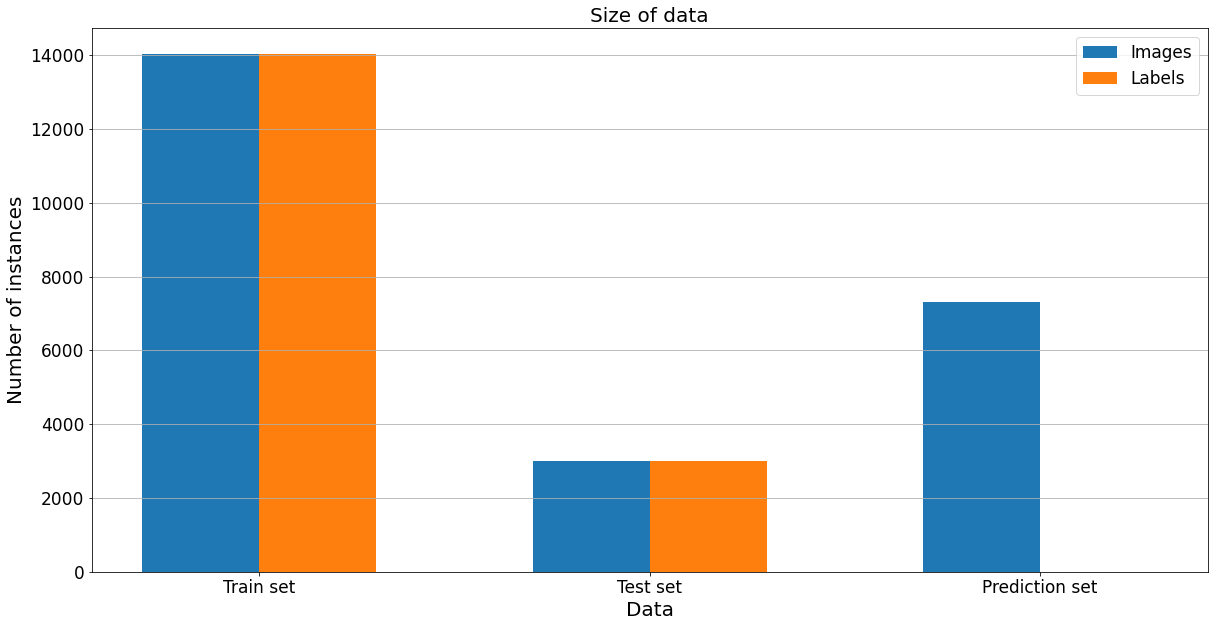

In [6]:
# Prepare data to plot
images_size = (len(train_images), len(test_images), len(pred_images))
labels_size = (train_labels.size, test_labels.size, 0)

# Create plot
fig, ax = plt.subplots()
fig.set_size_inches(20, 10)

# Create barplots
index = np.arange(3)
bar_width = 0.3

plt.bar(index,
        images_size,
        bar_width,
        color = 'tab:blue',
        label = 'Images')

plt.bar(index + bar_width,
        labels_size,
        bar_width,
        color = 'tab:orange',
        label = 'Labels')

# Manage appearance
plt.title('Size of data', fontsize = 20)
plt.xlabel('Data', fontsize = 20)
plt.ylabel('Number of instances', fontsize = 20)
plt.xticks(index + bar_width / 2, ('Train set', 'Test set', 'Prediction set'), fontsize = 17)
plt.yticks(fontsize = 17)
plt.legend(fontsize = 17)
plt.grid(axis = 'y')

plt.show()

In [7]:
train_percentage = round(100 * train_images.size / (train_images.size + test_images.size), 1)

train_percentage

82.4

The data was split into train and test sets with a ratio of about 82 to 18. The prediction set's labels are missing because images in that folder are unlabeled. The specific dimensions of the datasets are presented below.

In [8]:
# Dimensions of train set
print('Train images dimensions: ', train_images.shape)
print('Train labels dimensions: ', train_labels.shape)

# Dimensions of test set
print('Test imges dimensions: ', test_images.shape)
print('Test labels dimensions: ', test_labels.shape)

# Dimensions of prediction set
print('Prediction images dimensions: ', pred_images.shape)

Train images dimensions:  (14034, 100, 100, 3)
Train labels dimensions:  (14034,)
Test imges dimensions:  (3000, 100, 100, 3)
Test labels dimensions:  (3000,)
Prediction images dimensions:  (7301, 100, 100, 3)


The dimensions of the images is 100 * 100 pixels, while the number of channels is 3, meaning that the images have colors. Next, the number of images per image class in the train set is plotted.

In [9]:
def code_to_label(class_code):
    '''
    Get the label of a class code
    '''
    code_to_label = {0:'buildings', 1:'forest', 2:'glacier', 3:'mountain', 4:'sea', 5:'street'}
    
    return code_to_label[class_code]

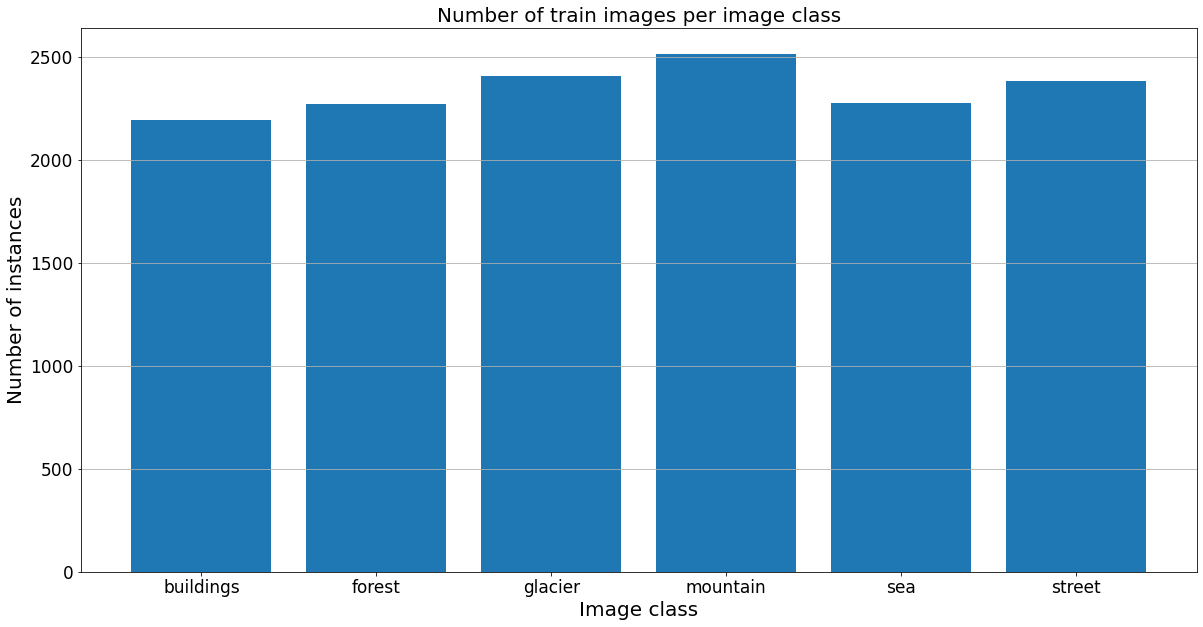

In [10]:
# Group train labels by label and count the number of instances
unique_labels, counts = np.unique(train_labels, return_counts = True)

# Create plot
plt.figure(figsize = (20, 10))

plt.bar(['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street'],
        counts,
        color = 'tab:blue')

# Manage appearance
plt.title('Number of train images per image class', fontsize = 20)
plt.xlabel('Image class', fontsize = 20)
plt.ylabel('Number of instances', fontsize = 20)
plt.xticks(fontsize = 17)
plt.yticks(fontsize = 17)
plt.grid(axis = 'y')

plt.show()

From the above plot, it is obvious that the train dataset is balanced, having more than 2000 instances per class. Finally, a sample of the train images is presented below.

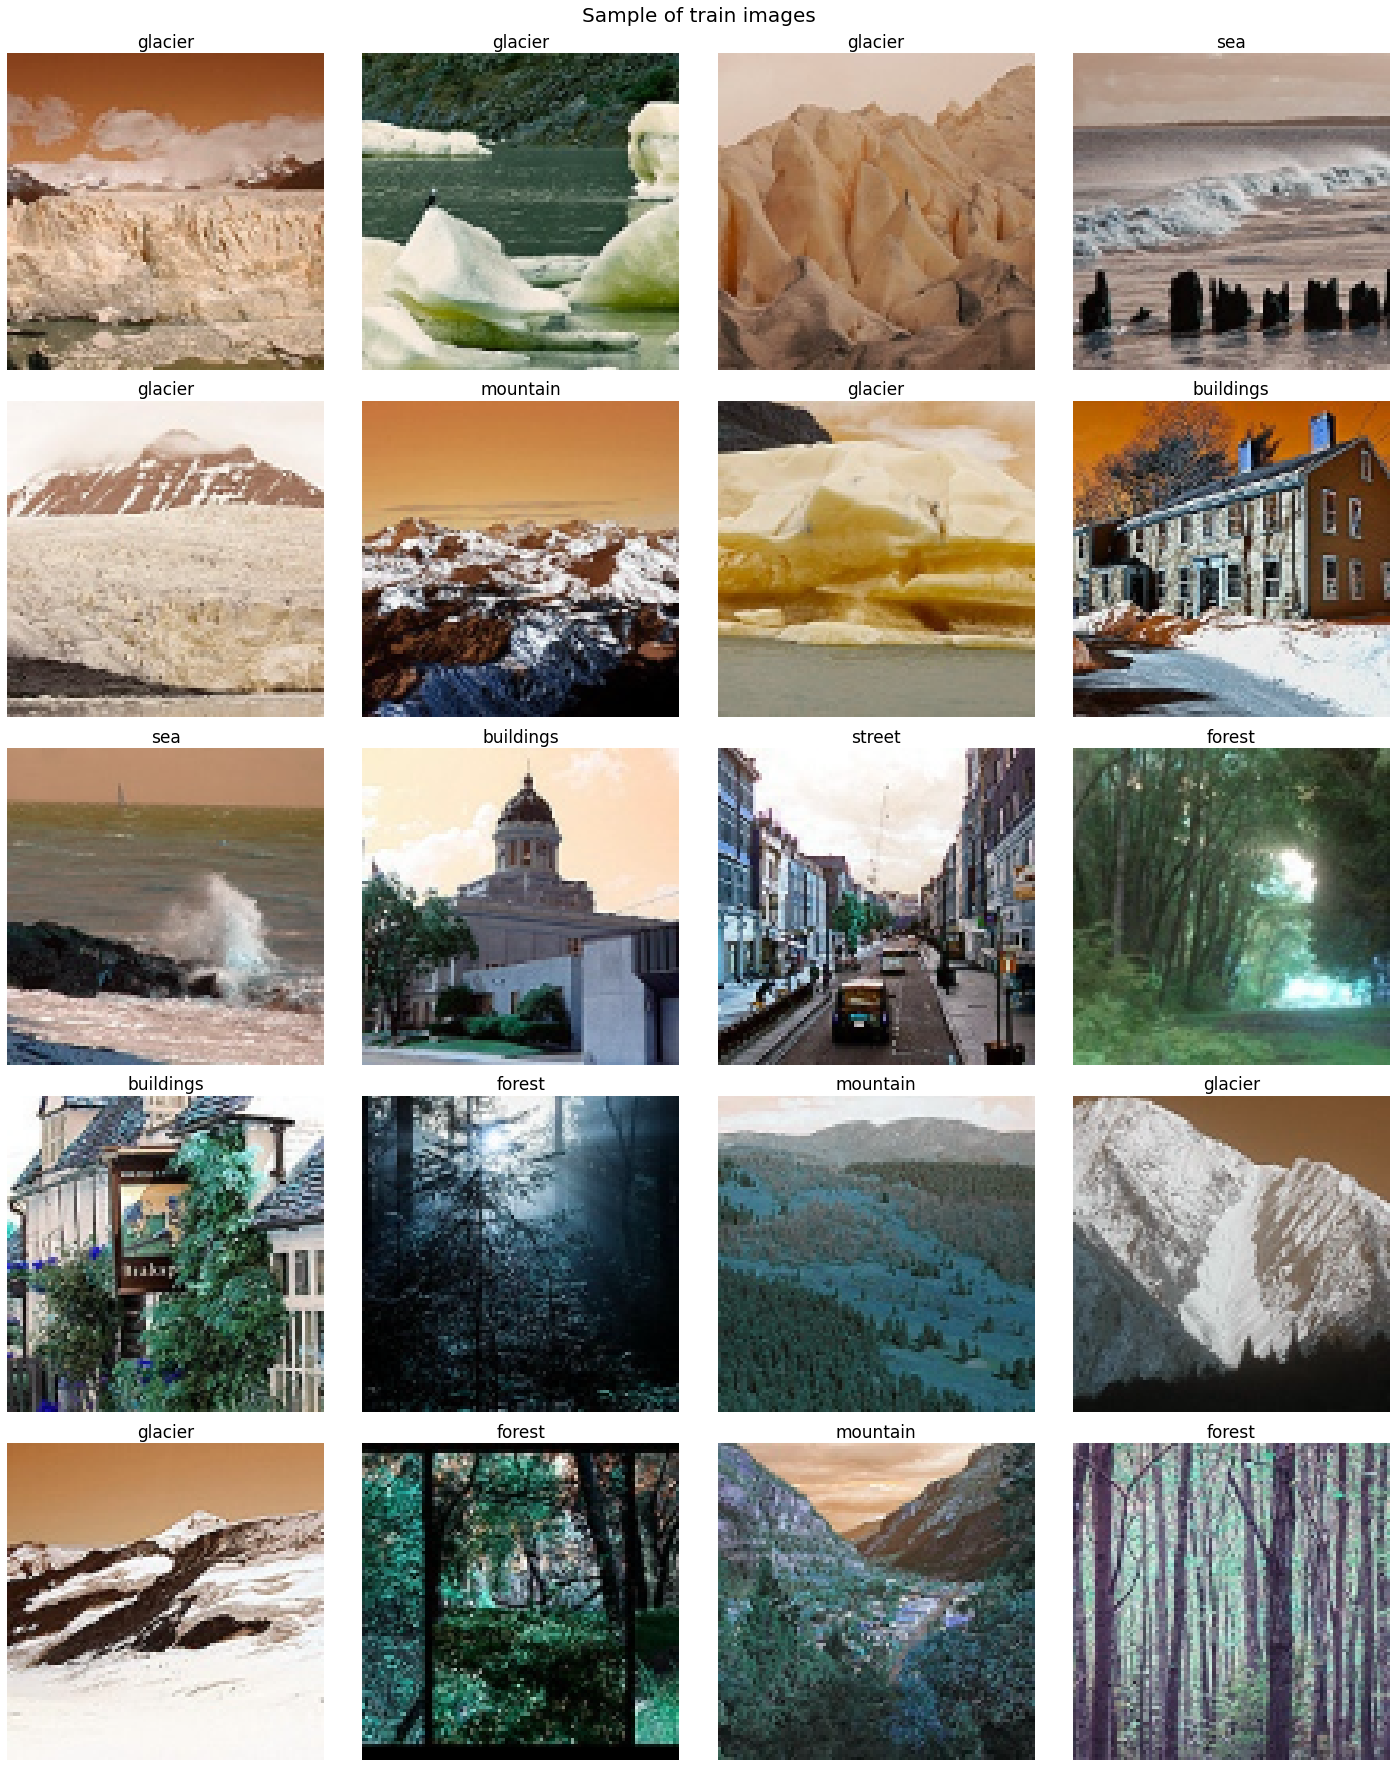

In [11]:
# Create plot
fig, ax = plt.subplots(5,4)
fig.set_size_inches(20, 25)
fig.suptitle('Sample of train images\n', fontsize = 20)

# Create subplots
for i in range(0,5):
    for j in range(0,4):
        # Pick a random image
        random_image = random.randint(0,len(train_images))
        
        # Create subplots
        ax[i,j].imshow(train_images[random_image])
        
        # Set label as image title
        ax[i,j].set_title(code_to_label(train_labels[random_image]), fontsize = 17)
        ax[i,j].axis('off')

# Manage appearance
plt.tight_layout()

plt.show()

# Models

In the section below, different models are going to be used to make the predictions, namely: Logistic Regression, XGBoost, a Convolutional Neural Network and a pretrained Convolutional Neural Network that uses transfer learning. As regards Logistic Regression and XGBoost, since they cannot handle image data by default, the images for them have to first be flattened. As for the neural network models, since they are more complex and require a lot of computing power and training time, they will be trained on a GPU.

In [12]:
# Flatten the images
train_images_flat = train_images.reshape(len(train_images), 100 * 100 * 3)
test_images_flat = test_images.reshape(len(test_images), 100 * 100 * 3)

## Logistic Regression model

In [13]:
# Create model
lr_model = LogisticRegression(max_iter = 100)

In [14]:
# Set timer
start_time = time.time()

# Train model
lr_model.fit(train_images_flat, train_labels)

# Time model
lr_time = round((time.time() - start_time) / 60, 1)

print('Logistic regression training time: ', lr_time, ' minutes')

Logistic regression training time:  0.7  minutes


/Users/Konstantinos/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [15]:
# Make predictions
lr_test_labels = lr_model.predict(test_images_flat)

In [16]:
def metrics(true_labels, predicted_labels):
    '''
    Print calssification metrics
    '''
    accuracy = sklearn.metrics.accuracy_score(true_labels, predicted_labels)
    precision = sklearn.metrics.precision_score(true_labels, predicted_labels, average = 'macro')
    recall = sklearn.metrics.recall_score(true_labels, predicted_labels, average = 'macro')
    f1 = sklearn.metrics.f1_score(true_labels, predicted_labels, average = 'macro')
    
    print('Accuracy: ', round(100 * accuracy, 2), '%')
    print('Precision: ', round(100 * precision, 2), '%')
    print('Recall: ', round(100 * recall, 2), '%')
    print('f1 score: ', round(100 * f1, 2), '%')

In [17]:
# Print metrics
metrics(test_labels, lr_test_labels)

Accuracy:  51.93 %
Precision:  51.95 %
Recall:  51.62 %
f1 score:  51.47 %


Changing the number of iterations did't improve the performance of the model, so it was set to the default value 100. The model accurately predicts the labels of about half of the images. This is a considerable increase from picking classes randomly (Since there are 6 classes, such a model would have an accuracy score of 100 / 6 = 16.7%), especially when taking into account the very short training time of the model.

## XGBoost model

The evaluation metric of the XGBoost classifier is set to multiclass logloss, because there are multiple classes.

In [18]:
# Create model
xgb_model = xgb.XGBClassifier(use_label_encoder = False, eval_metric = 'mlogloss')

In [19]:
# Set timer
start_time = time.time()

# Train model
xgb_model.fit(train_images_flat, train_labels)

# Time model
xgb_time = round((time.time() - start_time) / 60, 1)

print('XGBoost training time: ', xgb_time, ' minutes')

XGBoost training time:  24.8  minutes


In [20]:
# Make predictions
xgb_test_labels = xgb_model.predict(test_images_flat)

In [21]:
# Print metrics
metrics(test_labels, xgb_test_labels)

Accuracy:  66.23 %
Precision:  66.21 %
Recall:  65.98 %
f1 score:  65.8 %


There was a significant improvement on all the metrics, even with the default hyperparameters and, as expected, the training time got a lot longer.

In [22]:
# Delete flattened images
del train_images_flat
del test_images_flat

# Clean garbage from memory
gc.collect()

24

## Convolutional Neural Network model

The rationale behind the structure of the network is presented below:

* The 2D convolutional layers play a crucial role, as they are used to detect the presense of specific features in the images. The first one has to have an input shape of 100 * 100 to match the pictures' size. The dimensionality of the output space (filters) of each layer is then gradually reduced. The activation function chosen is relu and the size of the filter mask (kernel_size) is set to 3 * 3 pixels, common choices for such problems.
* The pooling layers are also essential, as they preserve only the important features of the images after each 2D convolutional set of layers, simultaneouly reducing the size of the images and, hence, the calculations. MaxPool layers are chosen to extract the largest element of each pool of size 5 * 5, another common choice for such problems.
* The flatten layer is used to make the images 1-dimensional.
* The 1D concolutional layers are used to reduce the dimensionality of the output space even more.
* The final layer uses softmax activation to match the final probabilities of occurance to each one of the 6 classes.
* The dropout layers and the use of regulizers will be discused later on.

In [23]:
# Create model
cnn_model = tf.keras.models.Sequential([
    # 1st set of 2D convolution layers
    tf.keras.layers.Conv2D(filters = 200,
                           kernel_size = (3,3),
                           activation = 'relu',
                           input_shape = (100, 100, 3)),
    tf.keras.layers.Conv2D(filters = 150,
                           kernel_size = (3,3),
                           activation = 'relu',
                           kernel_regularizer = tf.keras.regularizers.l2(l = 0.01)),
    
    # 1st pooling layer
    tf.keras.layers.MaxPool2D(pool_size = (5, 5)),
    
    # 1st dropout layer
    tf.keras.layers.Dropout(rate = 0.2),
    
    # 2nd set of 2D convolution layers
    tf.keras.layers.Conv2D(filters = 100,
                           kernel_size = (3, 3),
                           activation = 'relu'),
    tf.keras.layers.Conv2D(filters = 50,
                           kernel_size = (3, 3),
                           activation = 'relu',
                           kernel_regularizer = tf.keras.regularizers.l2(l = 0.01)),
    
    # 2nd pooling layer
    tf.keras.layers.MaxPool2D(pool_size = (5, 5)),
    
    # 2nd dropout layer
    tf.keras.layers.Dropout(rate = 0.2),
    
    # Flatten
    tf.keras.layers.Flatten(),
    
    # Set of 1D convolution layers
    tf.keras.layers.Dense(units = 150,
                          activation = 'relu'),
    tf.keras.layers.Dense(units = 50,
                          activation = 'relu'),
    
    # 3rd dropout layer
    tf.keras.layers.Dropout(rate = 0.2),
    
    # Calculate probabilities
    tf.keras.layers.Dense(units = 6,
                          activation = 'softmax')
])

cnn_model.summary()

Metal device set to: Apple M1 Pro
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 200)       5600      
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 150)       270150    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 19, 19, 150)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 19, 19, 150)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 100)       135100    
                                                                 
 conv2d_3 (Conv2D)           (None, 15, 15, 50)        45050     
                      

2022-03-03 21:34:12.992703: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-03 21:34:12.993482: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


The neural network is 13 layers deep and the total number of parameters to be trained is just over half a milion. The adam optimizer is chosen mainly for speed reasons and the sparse categorical crossentropy loss function is used because the problem has multiple classes. 20 epochs are expected to lead to some fairly accurate results and the learning rate is set based on the number of epochs.

In [24]:
# Compile model
cnn_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
                  loss = 'sparse_categorical_crossentropy',
                  metrics = ['Accuracy'])

# Set timer
start_time = time.time()

# Train model, also passing to a variable to plot it afterwards
history = cnn_model.fit(train_images,
                        train_labels,
                        epochs = 20,
                        validation_data = (test_images,test_labels))

# Time model
cnn_time = round((time.time() - start_time) / 60, 1)

print('CNN training time: ', cnn_time, ' minutes')

2022-03-03 21:34:15.512427: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/20


2022-03-03 21:34:15.738353: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


439/439 [==============================] - ETA: 0s - loss: 1.3296 - Accuracy: 0.5094

2022-03-03 21:36:08.201618: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


439/439 [==============================] - 118s 266ms/step - loss: 1.3296 - Accuracy: 0.5094 - val_loss: 1.1331 - val_Accuracy: 0.5517
Epoch 2/20
439/439 [==============================] - 115s 261ms/step - loss: 0.9837 - Accuracy: 0.6318 - val_loss: 0.8629 - val_Accuracy: 0.6980
Epoch 3/20
439/439 [==============================] - 114s 260ms/step - loss: 0.8730 - Accuracy: 0.6872 - val_loss: 0.7950 - val_Accuracy: 0.7247
Epoch 4/20
439/439 [==============================] - 115s 262ms/step - loss: 0.8244 - Accuracy: 0.7108 - val_loss: 0.7714 - val_Accuracy: 0.7397
Epoch 5/20
439/439 [==============================] - 115s 262ms/step - loss: 0.7634 - Accuracy: 0.7327 - val_loss: 0.6829 - val_Accuracy: 0.7713
Epoch 6/20
439/439 [==============================] - 116s 264ms/step - loss: 0.7202 - Accuracy: 0.7571 - val_loss: 0.7286 - val_Accuracy: 0.7533
Epoch 7/20
439/439 [==============================] - 117s 267ms/step - loss: 0.6917 - Accuracy: 0.7723 - val_loss: 0.6537 - val_Accura

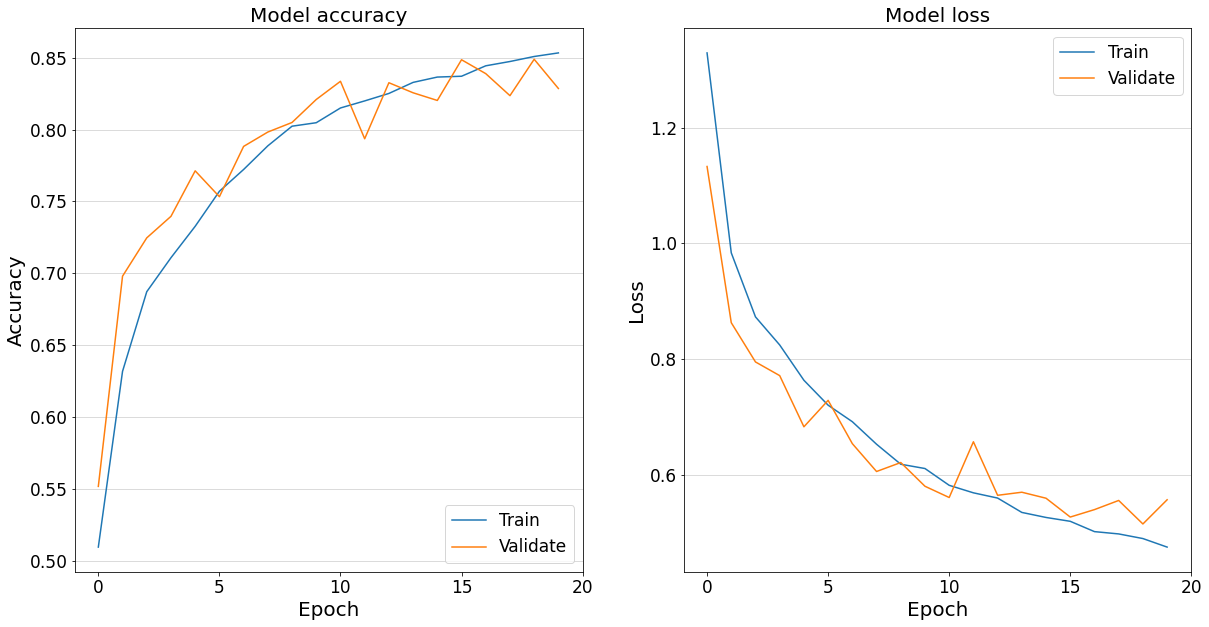

In [25]:
# Create plot
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(20, 10)

# Create accuracy subplot
ax1.plot(history.history['Accuracy'], color = 'tab:blue')
ax1.plot(history.history['val_Accuracy'], color = 'tab:orange')

ax1.set_title('Model accuracy', fontsize = 20)

ax1.set_xlabel('Epoch', fontsize = 20)
ax1.set_xticks(list(range(0, 21, 5)), fontsize = 17)
ax1.set_xticklabels(list(range(0, 21, 5)), fontsize = 17)

ax1.set_ylabel('Accuracy', fontsize = 20)
ax1.tick_params(axis = 'y', labelsize = 17)

ax1.set_facecolor('white')
ax1.grid(axis = 'y', color = 'lightgrey')
ax1.legend(['Train', 'Validate'], fontsize = 17, loc = 'lower right', facecolor = 'white')

# Create loss subplot
ax2.plot(history.history['loss'], color = 'tab:blue')
ax2.plot(history.history['val_loss'], color = 'tab:orange')
             
ax2.set_title('Model loss', fontsize = 20)

ax2.set_xlabel('Epoch', fontsize = 20)
ax2.set_xticks(list(range(0, 21, 5)), fontsize = 17)
ax2.set_xticklabels(list(range(0, 21, 5)), fontsize = 17)

ax2.set_ylabel('Loss', fontsize = 20)
ax2.tick_params(axis = 'y', labelsize = 17)

ax2.set_facecolor('white')
ax2.grid(axis = 'y', color = 'lightgrey')
ax2.legend(['Train', 'Validate'], fontsize = 17, loc = 'upper right', facecolor = 'white')

plt.show()

After several combinations of different network structures, kernel and pool sizes, the best f1 score achieved was around 80%. Despite having a dropout layer in the end that dropped 50% of the connections of the network, the validation accuracy after the 10th epoch failed to follow the upward trend of the training accuracy, meaning that the model was overfitting. This was solved when this layer was replaced with 3 others of a 20% dropout rate after every pooling layer and two l2 regulizers, one in each set of convolutional layers. This was also the model with the best performance.

In [26]:
# Predict probabilities for each class
cnn_test_labels = cnn_model.predict(test_images)

# Choose class with highest probability
cnn_test_labels = np.argmax(cnn_test_labels, axis = 1)

2022-03-03 22:13:04.690585: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [27]:
# Print metrics
metrics(test_labels, cnn_test_labels)

Accuracy:  82.87 %
Precision:  84.54 %
Recall:  82.91 %
f1 score:  82.83 %


The appropriate model selection and the longer training time led again to significantly improved metrics.

## Convolutional Neural Network model using Transfer Learning (Inception V3)

The CNN in this section is going to be built using transfer learning. The chosen CNN is Inception V3, because it performed well in the ImageNet image classification problem, achieving a 1% accuracy score of 78.95%, and does not have a very large number of parameters compared to other similar models (Papers with code, 2022). The model is already trained on the dataset, which involves more than 14 million images. The weights of the parameters were downloaded as a seperate file (Keras, 2022). The input shape is first set to the size of the images.

In [28]:
# Load pre-trained model
pre_trained_model = InceptionV3(input_shape = (100, 100, 3), 
                                include_top = False, 
                                weights = "imagenet")

# Load weights
pre_trained_model.load_weights('/Users/Konstantinos/Desktop/data/inception_v3_weights.h5')

# Initialize number of layers
number_of_layers = 0

# Make layers untrainabe
for layer in pre_trained_model.layers:
    layer.trainable = False
    number_of_layers += 1

number_of_layers

311

The neural network is 311 layers deep and the total number of parameters is close to 22 million, all of which are already trained. The best performance was found to happen when the neural network was used up to layer "mixed 7". For the layers after this, the compiling and the training process were performed based on the same principales as before with the only goal to configure the network on this problem. After several runs with different network structures and layer hyperparameters, the best performance was achieved using the model below. Interestingly, increasing the number of epochs to more than 1 didn't lead to better performance.

In [29]:
# Get the network up to layer mixed 7
last_layer = pre_trained_model.get_layer('mixed7')

last_layer.output_shape

(None, 4, 4, 768)

In [30]:
# Construct the final part of the network
x = tf.keras.layers.Flatten()(last_layer.output)
x = tf.keras.layers.Dense(1000, activation='relu')(x)
x = tf.keras.layers.Dense(200, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)                  
x = tf.keras.layers.Dense(6, activation='softmax')(x)      

In [31]:
# Construct model
inceptionV3_model = tf.keras.Model(pre_trained_model.input, x) 

# Compile model
inceptionV3_model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate = 0.0001), 
              loss = 'sparse_categorical_crossentropy', 
              metrics = ['Accuracy'])

# Set timer
start_time = time.time()

# Train model
inceptionV3_model.fit(train_images, train_labels, epochs = 1, validation_data = (test_images,test_labels))

# Time model
inceptionV3_time = round((time.time() - start_time) / 60, 1)

print('Inception V3 CNN training time: ', inceptionV3_time, ' minutes')

2022-03-03 22:13:19.693641: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


439/439 [==============================] - ETA: 0s - loss: 0.4491 - Accuracy: 0.8384

2022-03-03 22:13:33.019933: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


439/439 [==============================] - 18s 35ms/step - loss: 0.4491 - Accuracy: 0.8384 - val_loss: 0.3386 - val_Accuracy: 0.8747
Inception V3 CNN training time:  0.4  minutes


In [32]:
# Predict probabilities for each class
inceptionV3_test_labels = inceptionV3_model.predict(test_images)

# Choose class with highest probability
inceptionV3_test_labels = np.argmax(inceptionV3_test_labels, axis = 1)

2022-03-03 22:13:35.991751: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [33]:
# Print metrics
metrics(test_labels, inceptionV3_test_labels)

Accuracy:  87.47 %
Precision:  87.97 %
Recall:  87.69 %
f1 score:  87.71 %


The metrics of the model, especially when considering the training time, are definitelly stunning! A more detailed comparison between the models will happen in the next section.

## Models comparison

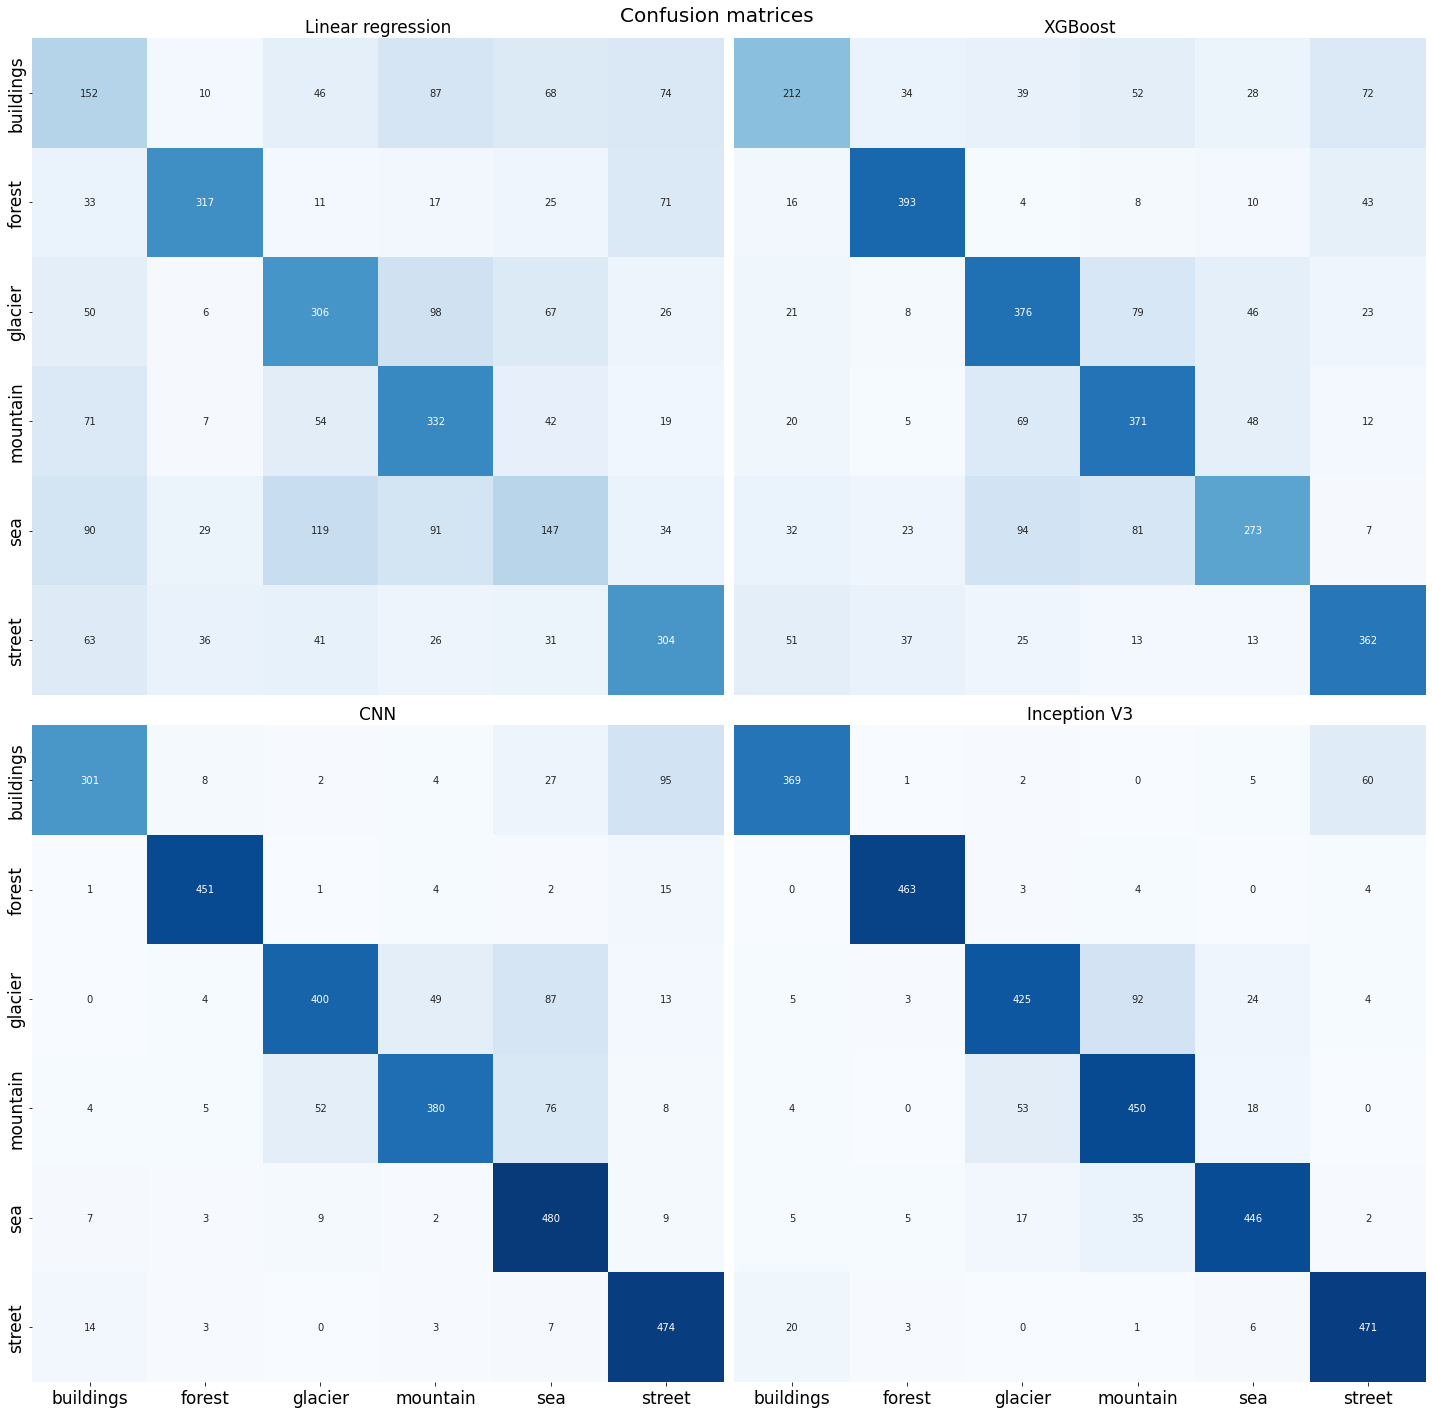

In [34]:
# Plot confusion matrices
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize=(20,20))
fig.suptitle('Confusion matrices', fontsize = 20)

# Linear regression
sns.heatmap(sklearn.metrics.confusion_matrix(test_labels, lr_test_labels),
            annot = True,
            cmap ='Blues',
            fmt = "",
            cbar = False,
            vmin = 0,
            vmax = 500,
            ax = axes[0, 0])
axes[0, 0].set_title('Linear regression', fontsize = 17)
axes[0, 0].get_xaxis().set_visible(False)
axes[0, 0].yaxis.set_ticklabels(['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street'], fontsize = 17)

# XGBoost
sns.heatmap(sklearn.metrics.confusion_matrix(test_labels, xgb_test_labels),
            annot = True,
            cmap ='Blues',
            fmt = "",
            cbar = False,
            vmin = 0,
            vmax = 500,
            ax = axes[0, 1])
axes[0, 1].set_title('XGBoost', fontsize = 17)
axes[0, 1].get_xaxis().set_visible(False)
axes[0, 1].get_yaxis().set_visible(False)

# CNN
sns.heatmap(sklearn.metrics.confusion_matrix(test_labels, cnn_test_labels),
            annot = True,
            cmap ='Blues',
            fmt = "",
            cbar = False,
            vmin = 0,
            vmax = 500,
            ax = axes[1, 0])
axes[1, 0].set_title('CNN', fontsize = 17)
axes[1, 0].xaxis.set_ticklabels(['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street'], fontsize = 17)
axes[1, 0].yaxis.set_ticklabels(['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street'], fontsize = 17)

# Inception V3
sns.heatmap(sklearn.metrics.confusion_matrix(test_labels, inceptionV3_test_labels),
            annot = True,
            cmap ='Blues',
            fmt = "",
            cbar = False,
            vmin = 0,
            vmax = 500,
            ax = axes[1, 1])
axes[1, 1].set_title('Inception V3', fontsize = 17)
axes[1, 1].xaxis.set_ticklabels(['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street'], fontsize = 17)
axes[1, 1].get_yaxis().set_visible(False)

plt.tight_layout()
plt.show()

The linear regression model struggles in recognizing most categories of images, with most of the errors concerning sea, mountain, glacier and building images. However, it manages street and forest images better. While the XGBoost confusion matrix looks a lot cleaner, there are still significant errors with those difficult classes. As regards the neural networks, they perform similarly, confusing only some instances of images that even the human eye struggles to classify. They tend to mislabel mainly mountain with glacier images and building with street images.

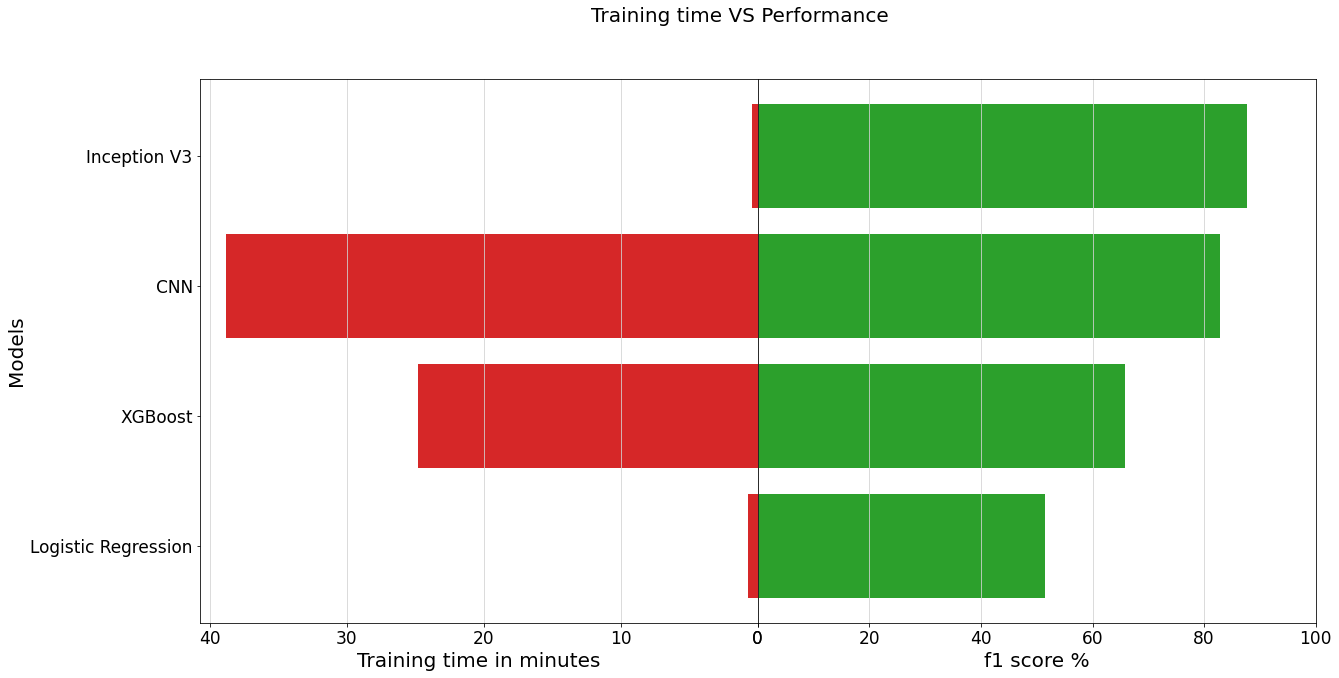

In [35]:
# Prepare data to plot
models = ['Logistic Regression', 'XGBoost', 'CNN', 'Inception V3']

f1_scores = [100 * sklearn.metrics.f1_score(test_labels, lr_test_labels, average = 'macro'),
             100 * sklearn.metrics.f1_score(test_labels, xgb_test_labels, average = 'macro'),
             100 * sklearn.metrics.f1_score(test_labels, cnn_test_labels, average = 'macro'),
             100 * sklearn.metrics.f1_score(test_labels, inceptionV3_test_labels, average = 'macro')]

training_times = [lr_time,
                  xgb_time,
                  cnn_time,
                  inceptionV3_time]

training_times = [-i for i in training_times] # Multiply by -1 to get plot on the left direction

# Create plot
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(20, 10)
fig.subplots_adjust(wspace = 0)
fig.suptitle('Training time VS Performance', fontsize = 20)

# Create training time subplot
ax1.barh(models,
        training_times,
        color = 'tab:red')
ax1.set_facecolor('white')
ax1.grid(axis = 'x', color = 'lightgrey')

ax1.set_xlabel('Training time in minutes', fontsize = 20)
ax1.set_xticks(list(range(-40, 1, 10)))
ax1.set_xticklabels(list(range(40, -1, -10)), fontsize = 17) # Create positive numbers for the negative ticks

ax1.set_ylabel('Models', fontsize = 20)
ax1.tick_params(axis = 'y', labelsize = 17)

# Create performance subplot
ax2.barh(models,
        f1_scores,
        color = 'tab:green')
ax2.set_facecolor('white')
ax2.grid(axis = 'x', color = 'lightgrey')

ax2.set_xlabel('f1 score %', fontsize = 20)
ax2.set_xticks(list(range(0, 101, 20)))
ax2.set_xticklabels(list(range(0, 101, 20)), fontsize = 17)

ax2.get_yaxis().set_visible(False)

plt.show()

It is obvious from the above graph that convolutional neural networks are very accurate in this image classification problem. The most interesting finding, however, is the great perfomance of the transfer learning model compared to it's very low training time (and also resources usage). It has to be stated at this point that the XGBoost model would have a better performance if tuned properly and would have a lower training time if also trained on a GPU.

# Best model evaluation

In this section, the best performing model, Inception V3, will be used to classify images of the test and prediction set.

## Evaluation on test set

In [36]:
# Predict test labels
predicted_test_labels = inceptionV3_model.predict(test_images)

In [37]:
def plot_image(image_number, images, labels):
    '''
    Construct image subplot
    '''
    # Create plot
    plt.imshow(images[image_number])
    
    # Manage appearance
    plt.axis('off')
    plt.title("True: " + code_to_label(labels[image_number]))

In [38]:
def plot_probabilities(image_number, labels, predicted_labels):
    '''
    Construct probabilities subplot
    '''
    # Change background
    plt.rcParams['axes.facecolor'] = 'white'
    
    # Create plot
    current_plot = plt.bar(range(6), 100 * predicted_labels[image_number], color = 'grey')

    # Make true category green and wrong category red
    predicted_category = np.argmax(predicted_labels[image_number])
    true_category = labels[image_number]
    current_plot[predicted_category].set_color('tab:red')
    current_plot[true_category].set_color('tab:green')
    
    # Set predicted probability as title
    predicted_label = code_to_label(predicted_category)
    predicted_probability = round(100 * np.max(predicted_labels[image_number]))
    plt.title('Predicted: ' + predicted_label + ' (' + str(predicted_probability) + '%)')
    plt.grid(axis = 'y', color = 'lightgrey')
    
    # Manage appearance
    plt.xticks(range(6), ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street'])
    plt.yticks(list(range(0, 101, 20)))

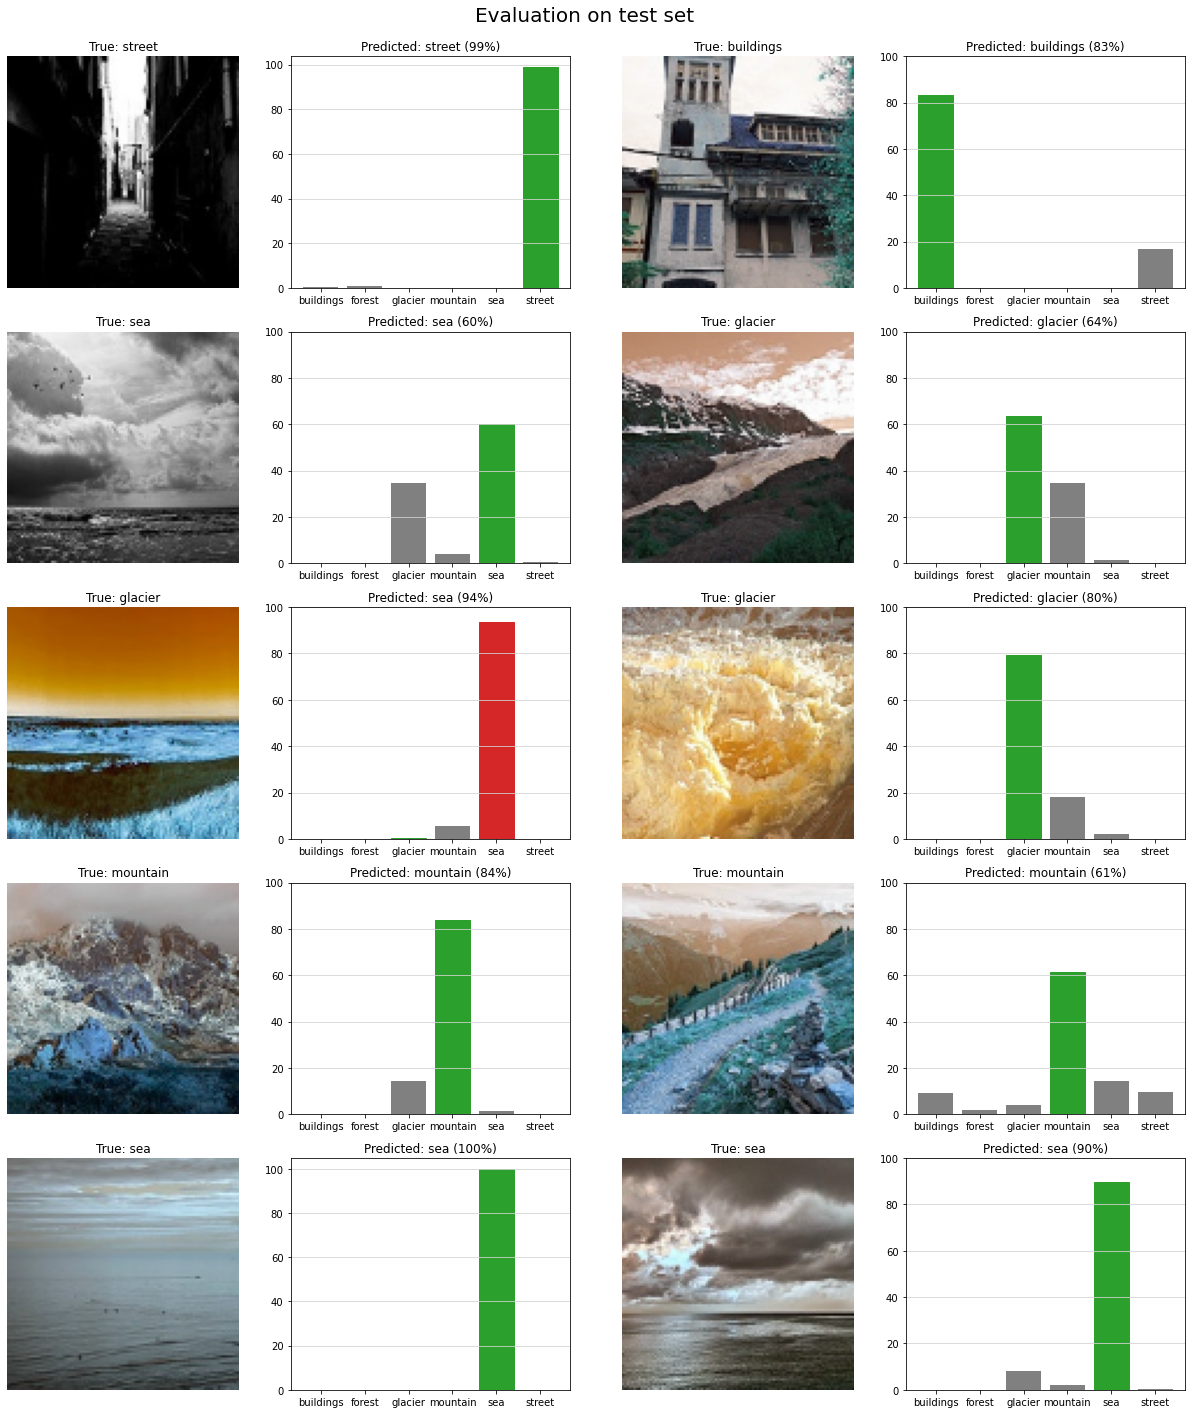

In [39]:
plt.figure(figsize = (17, 20))
plt.suptitle('Evaluation on test set\n', fontsize = 20)

for i in range(10):
    # Plot images
    plt.subplot(5, 4, 2 * i + 1)
    plot_image(i, test_images, test_labels)
    
    # Plot probabilities
    plt.subplot(5, 4, 2 * i + 2)
    plot_probabilities(i, test_labels, predicted_test_labels)

plt.tight_layout()

## Predictions on prediction set

In [40]:
# Predict prediction set labels
pred_labels = inceptionV3_model.predict(pred_images)

In [41]:
def plot_unknown_image(image_number, images):
    '''
    Plot image with unknown label
    '''
    plt.axis('off')
    plt.imshow(images[image_number])

In [42]:
def plot_unknown_probabilities(image_number, predicted_labels):
    '''
    Plot probabilities with unknown label
    '''
    # Change background
    plt.rcParams['axes.facecolor'] = 'white'
    
    # Create plot
    current_plot = plt.bar(range(6), 100 * predicted_labels[image_number], color = 'grey')
    
    # Set predicted probability as title
    predicted_category = np.argmax(predicted_labels[image_number])
    predicted_label = code_to_label(predicted_category)
    predicted_probability = round(100 * np.max(predicted_labels[image_number]))
    plt.title('Predicted: ' + predicted_label + ' (' + str(predicted_probability) + '%)')
    plt.grid(axis = 'y', color = 'lightgrey')
    
    # Manage appearance
    plt.xticks(range(6), ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street'])
    plt.yticks(list(range(0, 101, 20))) 

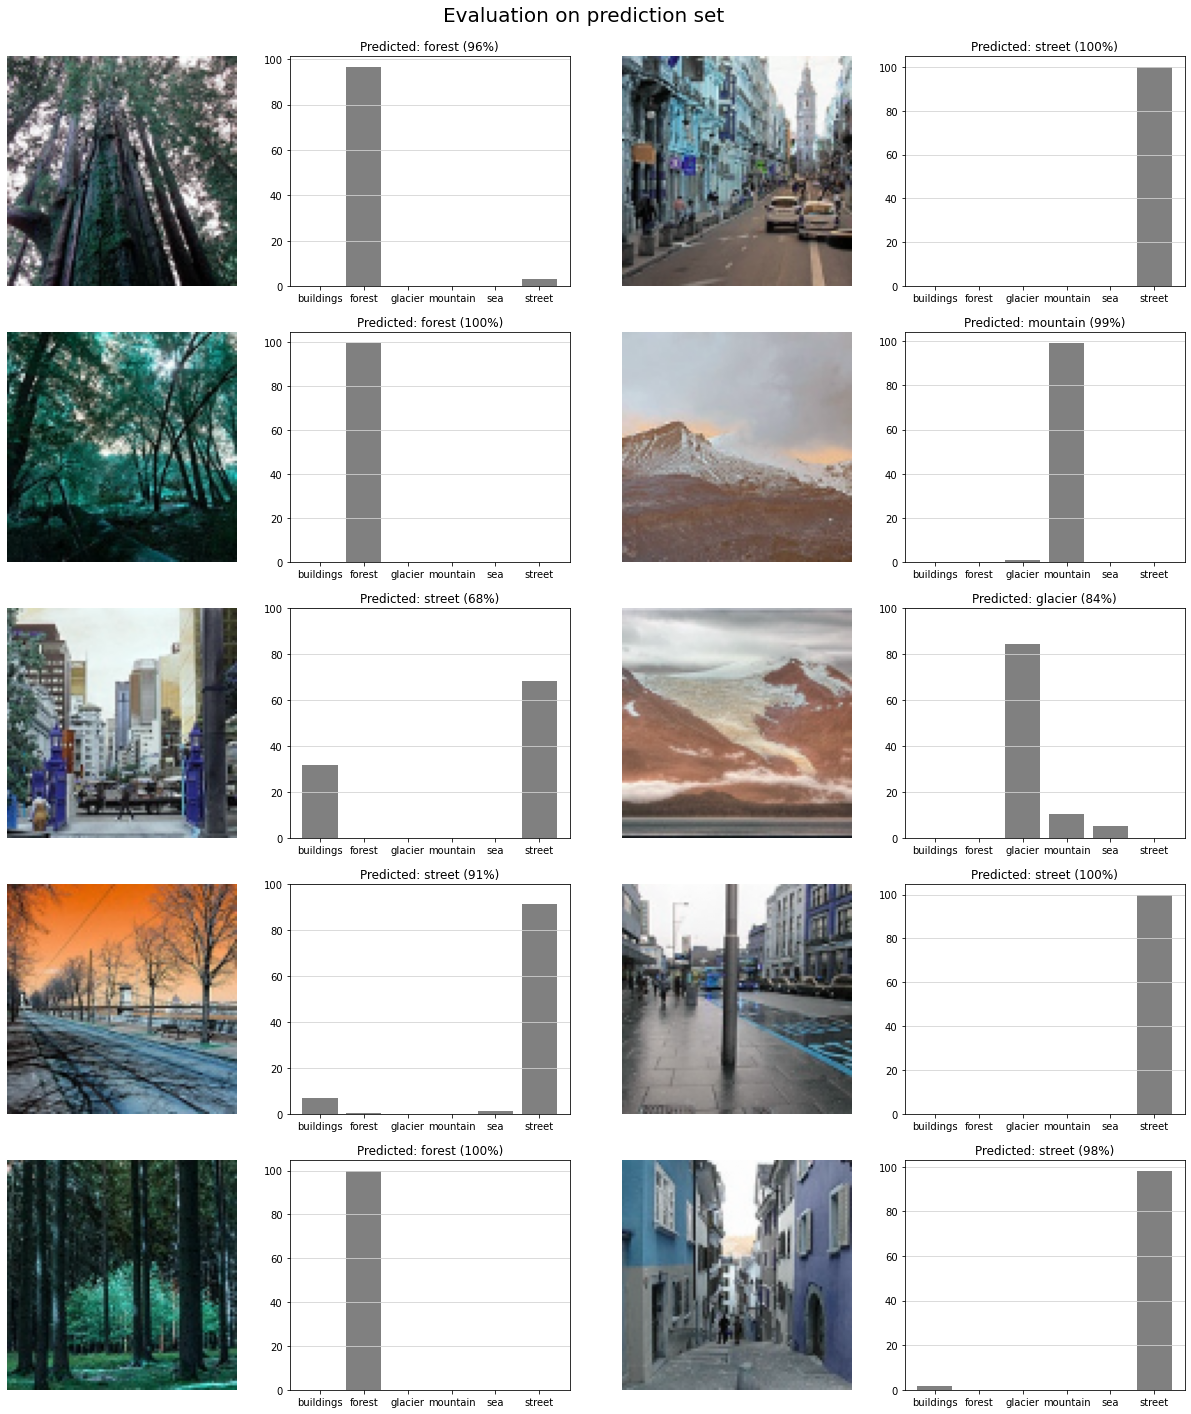

In [43]:
plt.figure(figsize = (17, 20))
plt.suptitle('Evaluation on prediction set\n', fontsize = 20)

for i in range(10):
    plt.subplot(5, 4, 2 * i + 1)
    plot_unknown_image(i, pred_images)
    plt.subplot(5, 4, 2 * i + 2)
    plot_unknown_probabilities(i, pred_labels)

plt.tight_layout(h_pad = 1.3)

In both the test and prediction sets, the model seems confident in most scenarios, struggling to identify only with the most demanging images.

# Conclusion

After accessing the images and visualising their main characteristics, several models were built and trained on them, producing some interesting results. First, the report validated that convolutional neural networks are in fact very accurate in image classification tasks, with more traditional machine learning models struggling with handling images. Furthermore, it demonstrated the power of transfer learning, proving that image problems can be handled properly even in situations with limited recources.

The main limitation of the report is related to the recources training image data requires. The amount of time required for training each of the models made hypertuning difficult, even with the use of a GPU. As stated before, XGBoost was used with its default hyperparameters and the CNNs could achieve even better metrics if tuned more properly.

Given more powerful recources or time, all models could be tuned equally and several transfer learning models could be compared with each other based on their performance, leading to better results on this problem.

# References

   Papers with code, 2022. Image Classification on ImageNet. [online] Paperswithcode.com. Available at: <https://paperswithcode.com/sota/image-classification-on-imagenet> [Accessed 1 March 2022].
    
   Bansal, P., 2019. Intel Image Classification. [online] Kaggle.com. Available at: <https://www.kaggle.com/puneet6060/intel-image-classification> [Accessed 1 March 2022].
    
   Keras, 2022. InceptionV3. [online] Kaggle.com. Available at: <https://www.kaggle.com/keras/inceptionv3> [Accessed 1 March 2022].